In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os

import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import shutil
import os
from tensorflow import keras
import tensorflow as tf

#from ...core import BaseRecording
#from baserecording import BaseRecording

import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre

#from deepinterpolation.trainor_collection import core_trainer
#from deepinterpolation.network_collection import unet_single_ephys_1024
#from deepinterpolation.generic import ClassLoader

from spikeinterface_generator import SpikeInterfaceRecordingSegmentGenerator

import numpy as np
import os

from spikeinterface.core.core_tools import define_function_from_class
from spikeinterface.preprocessing.basepreprocessor import BasePreprocessor, BasePreprocessorSegment
from spikeinterface.preprocessing.zero_channel_pad import ZeroChannelPaddedRecording
from spikeinterface.core import get_random_data_chunks
from spikeinterface.preprocessing.normalize_scale import ScaleRecordingSegment, NormalizeByQuantileRecording, ScaleRecording, CenterRecording, ZScoreRecording
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

#from spikeinterface.preprocessing import get_random_data_chunks


In [3]:
#path of the training_bp_filter_t20s_v0.5s
model_path = "/home/buccino/codes/ephys-deepinterpolation/spikeinterface/deepinterpolation_recording/trained_models/test_training_bp_filter_t20s_v0.5s/first_test_unet_single_ephys_1024_mean_absolute_error_model.h5"

In [4]:
#path of the recording
folder_path = Path("/home/buccino/data/Neuropixels2.0_Recording/open-ephys-np2/595262_2022-02-22_16-47-26/")
output_folder = Path("recording_saved")
if output_folder.is_dir():
    shutil.rmtree(output_folder)
recording = se.read_openephys(folder_path)
recording

OpenEphysBinaryRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 616.720s

In [5]:
recording_hp = spre.highpass_filter(recording)
recording_bp = spre.bandpass_filter(recording)

Calculating gain and offset "no_filter"

In [6]:
random_data = get_random_data_chunks(recording)
means = np.mean(random_data, axis=0)
means = means[None, :]
stds = np.std(random_data, axis=0)
stds = stds[None, :] 
gain = 1 / stds
gain_no_filter= gain
offset = -means / stds
offset_no_filter= offset


Calculating gain and offset "bandpass"

In [7]:
random_data = get_random_data_chunks(recording_bp)
means = np.mean(random_data, axis=0)
means = means[None, :]
stds = np.std(random_data, axis=0)
stds = stds[None, :] 
gain = 1 / stds
gain_bp_filter= gain
offset = -means / stds
offset_bp_filter= offset

Calculating gain and offset "highpass"

In [8]:
random_data = get_random_data_chunks(recording_hp)
means = np.mean(random_data, axis=0)
means = means[None, :]
stds = np.std(random_data, axis=0)
stds = stds[None, :] 
gain = 1 / stds
gain_hp_filter= gain
offset = -means / stds
offset_hp_filter= offset

Normalization using zscore

In [9]:
rec_norm_no = spre.zscore(recording)
rec_norm_hp = spre.zscore(recording_hp)
rec_norm_bp = spre.zscore(recording_bp)

Defining needed classes and functions

In [10]:
def has_tf(use_gpu=True, disable_tf_logger=True):
    try:
        import_tf(use_gpu, disable_tf_logger)
        return True
    except ImportError:
        return False
    
def import_tf(use_gpu=True, disable_tf_logger=True):
    import tensorflow as tf

    if not use_gpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

    if disable_tf_logger:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
        tf.get_logger().setLevel('ERROR')

    tf.compat.v1.disable_eager_execution()
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
    return tf

In [11]:
class DeepInterpolatedRecordingSegment(BasePreprocessorSegment):

    def __init__(self, recording_segment, model,
                 pre_frames, post_frames, pre_post_omission,
                 batch_size, use_gpu, desired_shape,
                 disable_tf_logger):
        BasePreprocessorSegment.__init__(self, recording_segment)

        self.model = model
        self.pre_frames = pre_frames
        self.post_frames = post_frames
        self.pre_post_omission = pre_post_omission
        self.batch_size = batch_size
        self.use_gpu = use_gpu
        self.desired_shape=desired_shape


        # creating class dynamically to use the imported TF with GPU enabled/disabled based on the use_gpu flag
        # self.SpikeInterfaceGenerator = SpikeInterfaceRecordingSegmentGenerator #define_input_generator_class( use_gpu, disable_tf_logger)

    def get_traces(self, start_frame, end_frame, channel_indices):
        n_frames = self.parent_recording_segment.get_num_samples()

        if start_frame == None:
            start_frame = 0

        if end_frame == None:
            end_frame = n_frames

        # for frames that lack full training data (i.e. pre and post frames including omissinos),
        # just return uninterpolated
        if start_frame < self.pre_frames+self.pre_post_omission:
            true_start_frame = self.pre_frames+self.pre_post_omission
            array_to_append_front = self.parent_recording_segment.get_traces(start_frame=0,
                                                                             end_frame=true_start_frame,
                                                                             channel_indices=channel_indices)
        else:
            true_start_frame = start_frame

        if end_frame > n_frames-self.post_frames-self.pre_post_omission:
            true_end_frame = n_frames-self.post_frames-self.pre_post_omission
            array_to_append_back = self.parent_recording_segment.get_traces(start_frame=true_end_frame,
                                                                            end_frame=n_frames,
                                                                            channel_indices=channel_indices)
        else:
            true_end_frame = end_frame

        # instantiate an input generator that can be passed directly to model.predict
        input_generator = SpikeInterfaceRecordingSegmentGenerator(recording_segment=self.parent_recording_segment,
                                                                  start_frame=true_start_frame,
                                                                  end_frame=true_end_frame,
                                                                  pre_frame=self.pre_frames,
                                                                  post_frame=self.post_frames,
                                                                  pre_post_omission=self.pre_post_omission,
                                                                  batch_size=self.batch_size)
        input_generator.randomize = False
        input_generator._calculate_list_samples(input_generator.total_samples)
        di_output = self.model.predict(input_generator, verbose=2)

        out_traces = input_generator.reshape_output(di_output)

        if true_start_frame != start_frame: # related to the restriction to be applied from the start and end frames around 0 and end
            out_traces = np.concatenate(
                (array_to_append_front, out_traces), axis=0)

        if true_end_frame != end_frame:
            out_traces = np.concatenate(
                (out_traces, array_to_append_back), axis=0)

        return out_traces[:, channel_indices]
   

In [12]:
class DeepInterpolatedRecording(BasePreprocessor):
    name = 'deepinterpolate'

    def __init__(self, recording, model_path: str,
                 pre_frames: int = 30, post_frames: int = 30, pre_post_omission: int = 1,
                 batch_size=128, use_gpu: bool = True, disable_tf_logger: bool = True):
        assert has_tf(
            use_gpu, disable_tf_logger), "To use DeepInterpolation, you first need to install `tensorflow`."
        
        self.tf = import_tf(use_gpu, disable_tf_logger)
        
        # try move model load here with spawn
        BasePreprocessor.__init__(self, recording)

        # first time retrieving traces check that dimensions are ok
        keras.backend.clear_session()
        model = keras.models.load_model(filepath=model_path)

        # check shape (this will need to be done at inference)
        network_input_shape = model.get_config()["layers"][0]["config"]["batch_input_shape"]
        desired_shape = network_input_shape[1:3]
        assert desired_shape[0]*desired_shape[1] == recording.get_num_channels(), "text"
        assert network_input_shape[-1] == pre_frames + post_frames


        # local_data = get_random_data_chunks(
        #    recording, **random_chunk_kwargs)
        # if isinstance(recording, ZeroChannelPaddedRecording):
        #    local_data = local_data[:, recording.channel_mapping]

        # local_mean = np.mean(local_data.flatten())
        # local_std = np.std(local_data.flatten())
        self.model = model
        # add segment
        for segment in recording._recording_segments:
            recording_segment = DeepInterpolatedRecordingSegment(segment, self.model,
                                                                 pre_frames, post_frames, pre_post_omission,
                                                                 batch_size, use_gpu,
                                                                 disable_tf_logger, desired_shape)
            self.add_recording_segment(recording_segment)

        self._preferred_mp_context = "spawn"
        self._kwargs = dict(recording=recording.to_dict(), model_path=model_path,
                            pre_frames=pre_frames, post_frames=post_frames, pre_post_omission=pre_post_omission,
                            batch_size=batch_size, desired_shape=desired_shape, use_gpu=use_gpu,
                            disable_tf_logger=disable_tf_logger)
        self.extra_requirements.extend(['tensorflow'])

Bandpass then Deepinterpolation

In [13]:
#path of the training_bp_filter_t20s_v0.5s
model_path = "/home/buccino/codes/ephys-deepinterpolation/spikeinterface/deepinterpolation_recording/trained_models/test_training_bp_filter_t20s_v0.5s/first_test_unet_single_ephys_1024_mean_absolute_error_model.h5"

In [14]:
rec_di_bp = DeepInterpolatedRecording(rec_norm_bp, model_path=model_path, pre_frames=30, 
                                   post_frames=30, pre_post_omission=1, disable_tf_logger=True,
                                   use_gpu=True)
print(rec_di_bp)

DeepInterpolatedRecording: 384 channels - 1 segments - 30.0kHz - 616.720s


In [15]:
traces_or = rec_norm_bp.get_traces(start_frame=3000, end_frame=13005)
traces_or.shape

(10005, 384)

In [16]:
traces_bp_di = rec_di_bp.get_traces(start_frame=3000, end_frame=13005)

/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


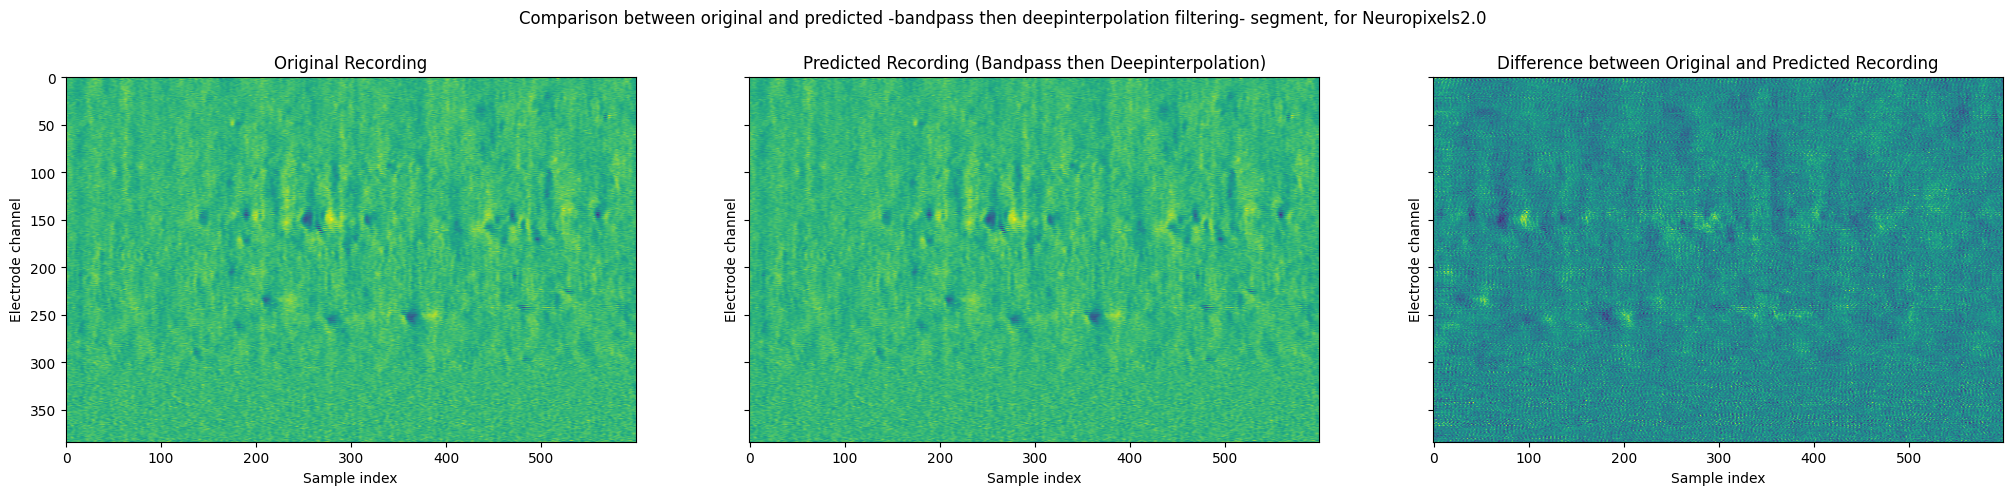

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(25, 25))

diff_bp_di = traces_or - traces_bp_di

ax1.imshow(traces_or[:600].T)
ax2.imshow(traces_bp_di[:600].T)
ax3.imshow(diff_bp_di[:600].T)

ax1.set_xlabel('Sample index')
ax1.set_ylabel('Electrode channel')
ax1.set_title('Original Recording')

ax2.set_xlabel('Sample index')
ax2.set_ylabel('Electrode channel')
ax2.set_title('Predicted Recording (Bandpass then Deepinterpolation)')

ax3.set_xlabel('Sample index')
ax3.set_ylabel('Electrode channel')
ax3.set_title('Difference between Original and Predicted Recording')

fig.suptitle('Comparison between original and predicted -bandpass then deepinterpolation filtering- segment, for Neuropixels2.0')
plt.subplots_adjust(top=1.65)

#plt.savefig('/home/buccino/Visual Results/Spikeinterface/Neuropixels1.0/Visual graph/Comparison between original and predicted -bandpass then deepinterpolation filtering- segment, for Neuropixels2.0 recording.png')

Text(0, 0.5, 'Amplitude')

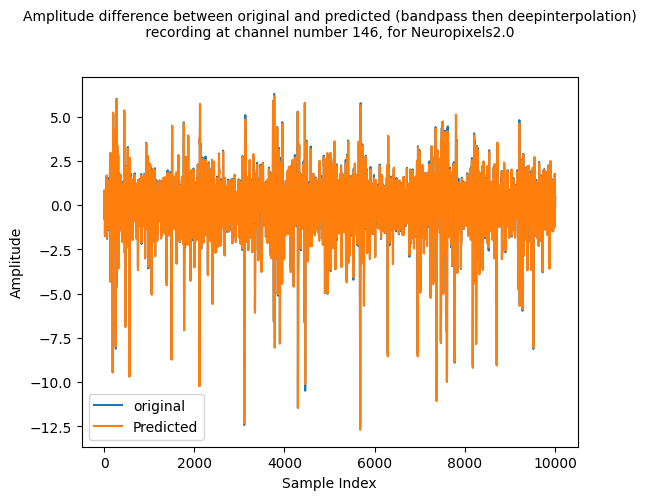

In [18]:
plt.figure()
plt.title("Amplitude difference between original and predicted (bandpass then deepinterpolation)" 
          "\n recording at channel number 146, for Neuropixels2.0 \n \n", fontsize=10, loc='center')
plt.plot(traces_or[:, 145], label="original"), # blue is for original recording
plt.plot(traces_bp_di[:, 145], label="Predicted"), #orange is for for filtered signal
plt.legend()

plt.xlabel('Sample Index')
plt.ylabel('Amplitude')


#plt.savefig('/home/buccino/Visual Results/Spikeinterface/Neuropixels1.0/Amplitude/original and predicted (bandpass then deepinterpolation).png')

In [19]:
# diff_bp_di dimensions (10005, 384)
diff_bp_di=diff_bp_di
# Calculate the sum of all rows using np.sum() with axis=1
average_diff_bp_di = np.mean(diff_bp_di, axis=1)
#if the shape is (384,) and not (10005,), rerun the cell
diff_bp_di.shape


(10005, 384)

In [20]:
average_diff_bp_di.shape

(10005,)

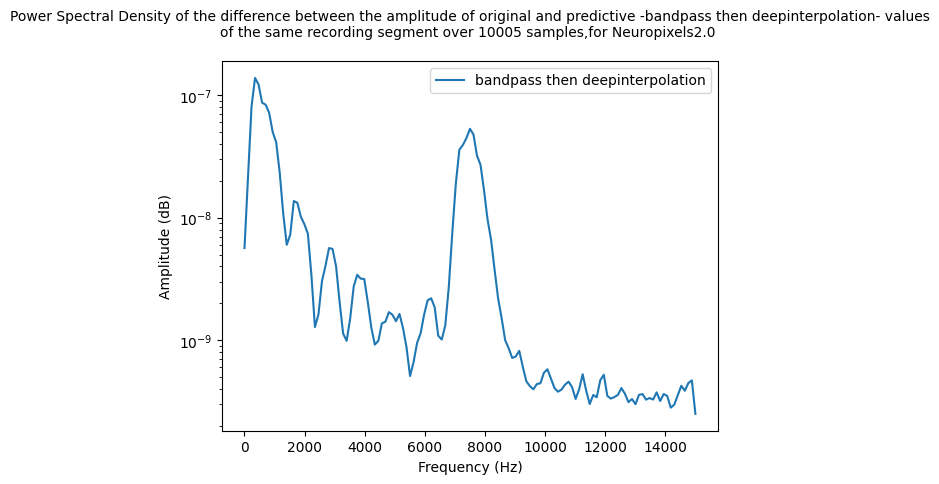

In [21]:
x= average_diff_bp_di
fs= 30000
f, Pxx = signal.welch(x, fs=fs)

# Plot the power spectrum density

fig, ax = plt.subplots()
ax.semilogy(f, Pxx,   label='bandpass then deepinterpolation')

ax.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (dB)')
ax.set_title('Power Spectral Density of the difference between the amplitude of original and predictive -bandpass then deepinterpolation- values\n' 
             "of the same recording segment over 10005 samples,for Neuropixels2.0 \n", size=10)
plt.show()

In [63]:
recording_di_bp_filter_rescaled= spre.scale(rec_di_bp, gain= gain_bp_filter, offset= offset_bp_filter, dtype='int16')

In [66]:
rec_di_hp_saved = recording_di_bp_filter_rescaled.save(folder="/home/buccino/codes/ephys-deepinterpolation/record_rescale/recording_di_bp_filter_rescaled", n_jobs=3, chunk_duration="1s")

write_binary_recording with n_jobs = 3 and chunk_size = 30000


/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
Exception in initializer:
Traceback (most recent call last):
  File "/home/buccino/miniconda3/envs/si/lib/python3.8/concurrent/futures/process.py", line 226, in _process_worker
    initializer(*initargs)
  File "/home/buccino/miniconda3/envs/si/lib/python3.8/site-packages/spikeinterface-0.96.2.dev0-py3.8.egg/spikeinterface/cor

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

Deepinterpolation then Bandpass

In [22]:
model_no_filter = "/home/buccino/codes/ephys-deepinterpolation/spikeinterface/deepinterpolation_recording/trained_models/test_training_no_hp_filter_t20s_v0.5s/first_test_unet_single_ephys_1024_mean_absolute_error_model.h5"

In [23]:
rec_norm_no_bp = spre.bandpass_filter(rec_norm_no)

In [24]:
rec_di_no = DeepInterpolatedRecording(rec_norm_no, model_path=model_no_filter, pre_frames=30, 
                                      post_frames=30, pre_post_omission=1, disable_tf_logger=True,
                                      use_gpu=True)
rec_di_no_bp = spre.bandpass_filter(rec_di_no)

In [25]:
traces_or_bp = rec_norm_no_bp.get_traces(start_frame=3000, end_frame=13005)
traces_di_bp1 = rec_di_no_bp.get_traces(start_frame=3000, end_frame=13005)

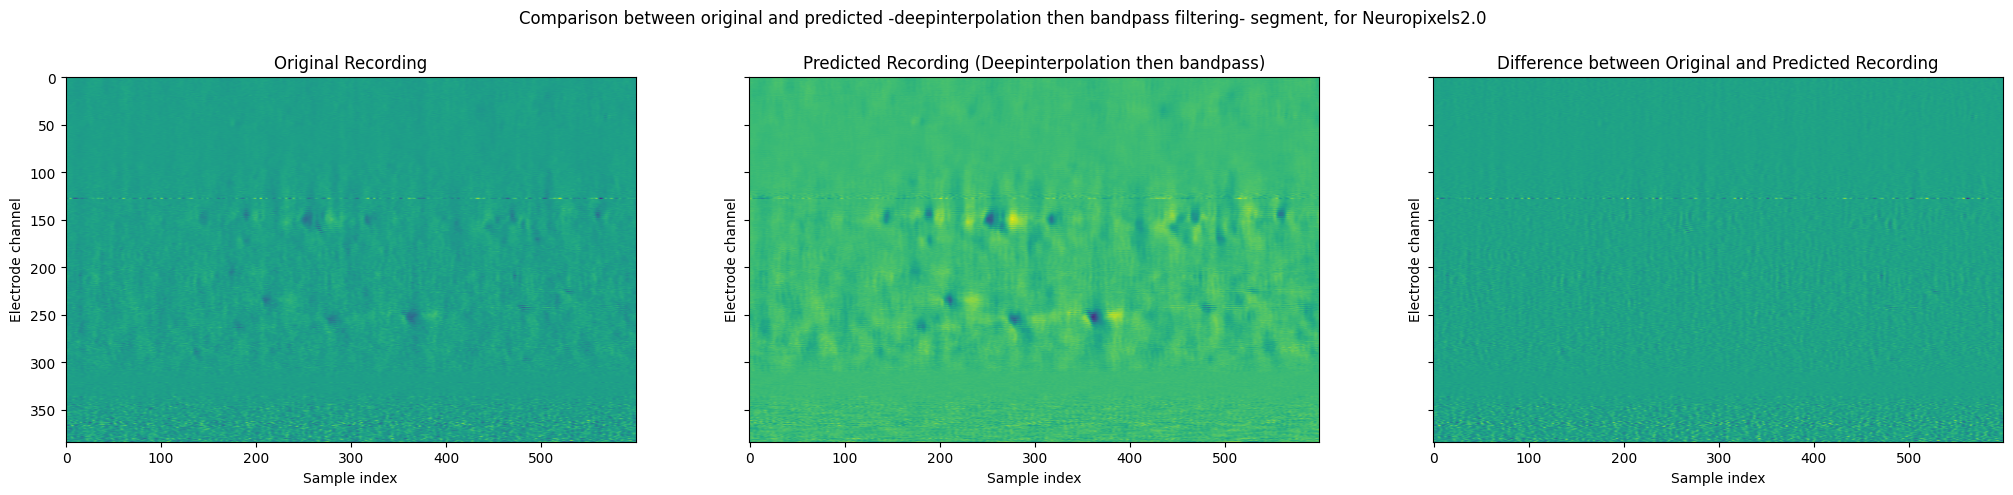

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(25, 25))

diff_di_bp1 = traces_or_bp - traces_di_bp1

ax1.imshow(traces_or_bp[:600].T)
ax2.imshow(traces_di_bp1[:600].T)
ax3.imshow(diff_di_bp1[:600].T)

ax1.set_xlabel('Sample index')
ax1.set_ylabel('Electrode channel')
ax1.set_title('Original Recording')

ax2.set_xlabel('Sample index')
ax2.set_ylabel('Electrode channel')
ax2.set_title('Predicted Recording (Deepinterpolation then bandpass)')

ax3.set_xlabel('Sample index')
ax3.set_ylabel('Electrode channel')
ax3.set_title('Difference between Original and Predicted Recording')

fig.suptitle('Comparison between original and predicted -deepinterpolation then bandpass filtering- segment, for Neuropixels2.0')
plt.subplots_adjust(top=1.65)

Text(0, 0.5, 'Amplitude')

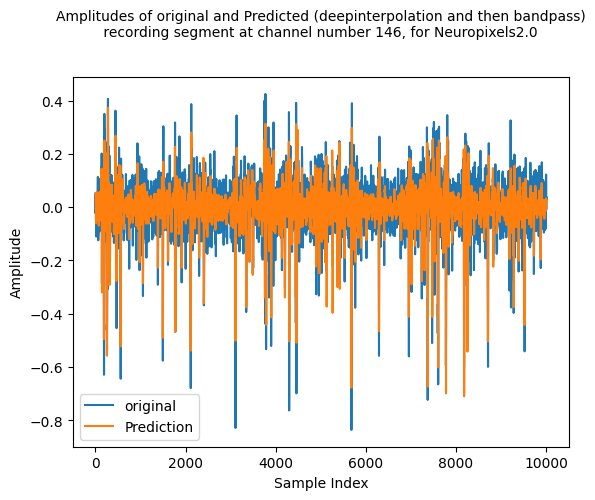

In [27]:
plt.figure()
plt.title("Amplitudes of original and Predicted (deepinterpolation and then bandpass)" 
          "\n recording segment at channel number 146, for Neuropixels2.0 \n \n", fontsize=10, loc='center')
plt.plot(traces_or_bp[:, 145], label="original"), # blue is for original recording
plt.plot(traces_di_bp1[:, 145], label="Prediction"), #orange is for for filtered signal
plt.legend()

plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

#plt.savefig('/home/buccino/Visual Results/Spikeinterface/Neuropixels1.0/Visual graph/Comparison between original and Predicted -deepinterpolation then bandpass- segment, for Neuropixels2.0.png')

In [28]:
# diff_bp_di dimensions (10005, 384)
diff_di_bp1 = diff_di_bp1
diff_di_bp1.shape
# Calculate the sum of all rows using np.sum() with axis=1
average_diff_di_bp1 = np.mean(diff_di_bp1, axis=1)
average_diff_di_bp1.shape
#if the shape is (384,) and not (10005,), rerun the cell

(10005,)

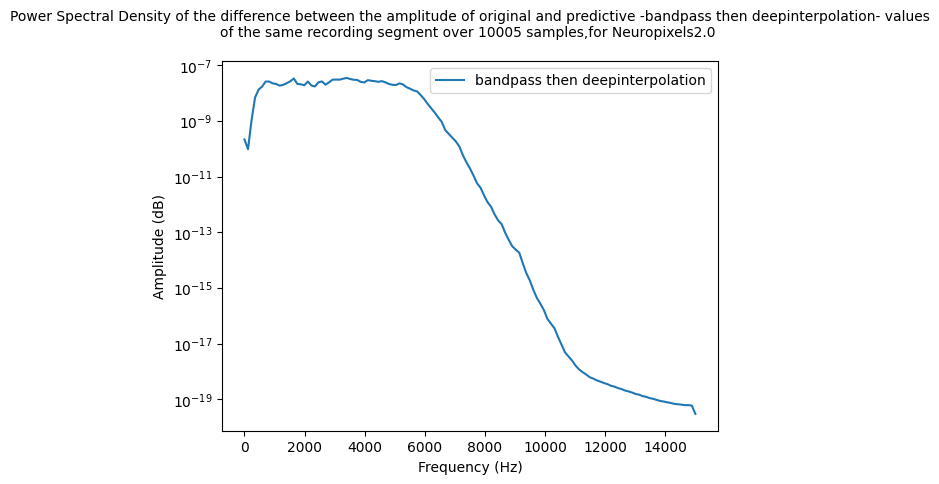

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

x= average_diff_di_bp1
fs= 30000
f, Pxx = signal.welch(x, fs=fs)

# Plot the power spectrum density

fig, ax = plt.subplots()
ax.semilogy(f, Pxx,   label='bandpass then deepinterpolation')

ax.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (dB)')
ax.set_title('Power Spectral Density of the difference between the amplitude of original and predictive -bandpass then deepinterpolation- values\n' 
             "of the same recording segment over 10005 samples,for Neuropixels2.0 \n", size=10)
plt.show()

Highpass then deepinterpolation

In [30]:
model_hp_filter = "/home/buccino/codes/ephys-deepinterpolation/spikeinterface/deepinterpolation_recording/trained_models/test_training_hp_filter_t20s_v0.5s/first_test_unet_single_ephys_1024_mean_absolute_error_model.h5"

In [31]:
rec_di_hp = DeepInterpolatedRecording(rec_norm_hp, model_path=model_hp_filter, pre_frames=30, 
                                      post_frames=30, pre_post_omission=1, disable_tf_logger=True,
                                      use_gpu=True)

In [34]:
spre.scale? # needed to scale the the recording with gain and offset

SyntaxError: invalid syntax (4120599474.py, line 1)

In [35]:
rec_di_hp_saved = rec_di_hp.save(folder="", n_jobs=1, chunk_duration="1s")

AssertionError: folder . already exists, choose another name

In [32]:
traces_or = rec_norm_hp.get_traces(start_frame=3000, end_frame=13005)
traces_hp_di = rec_di_hp.get_traces(start_frame=3000, end_frame=13005)


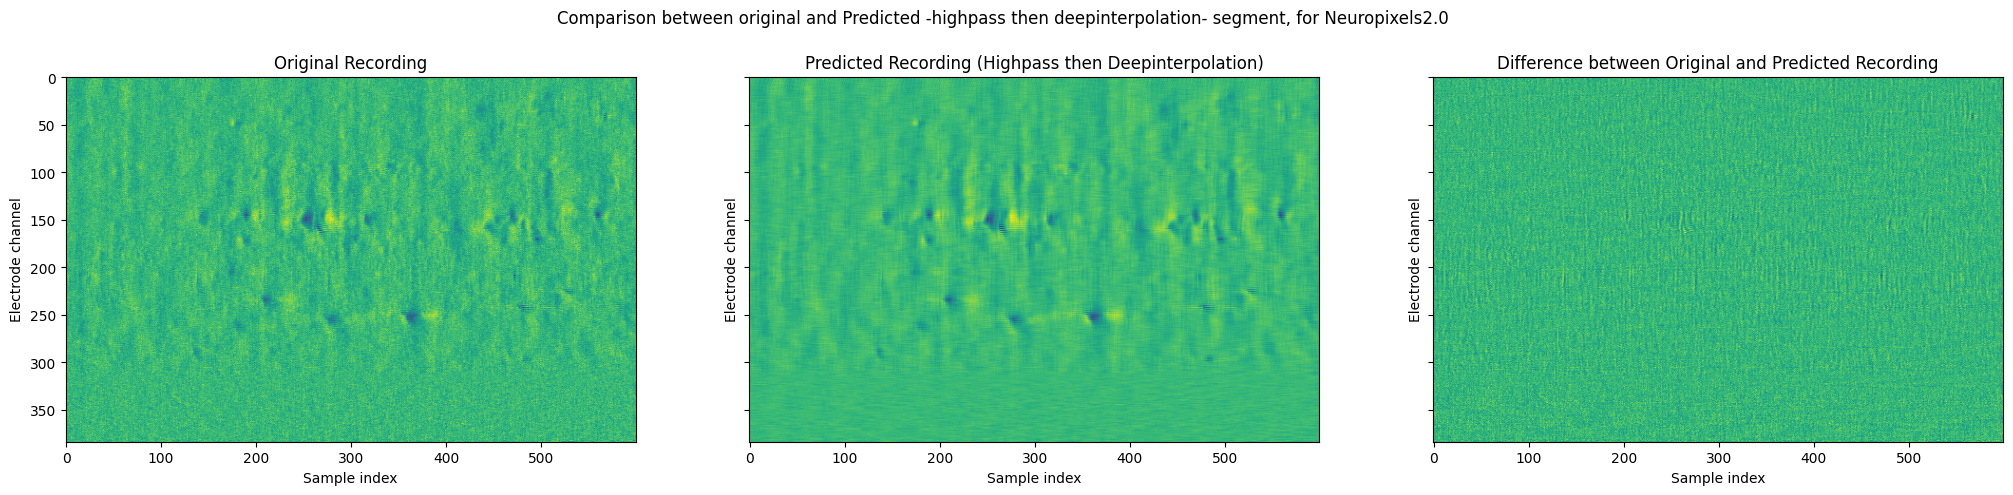

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(25, 25))

diff_hp_di = traces_or - traces_hp_di

ax1.imshow(traces_or[:600].T)
ax2.imshow(traces_hp_di[:600].T)
ax3.imshow(diff_hp_di[:600].T)

ax1.set_xlabel('Sample index')
ax1.set_ylabel('Electrode channel')
ax1.set_title('Original Recording')

ax2.set_xlabel('Sample index')
ax2.set_ylabel('Electrode channel')
ax2.set_title('Predicted Recording (Highpass then Deepinterpolation)')

ax3.set_xlabel('Sample index')
ax3.set_ylabel('Electrode channel')
ax3.set_title('Difference between Original and Predicted Recording')

fig.suptitle('Comparison between original and Predicted -highpass then deepinterpolation- segment, for Neuropixels2.0')
plt.subplots_adjust(top=1.65)

#plt.savefig('/home/buccino/Visual Results/Spikeinterface/Neuropixels1.0/Visual graph/Comparison between original and Predicted -highpass then deepinterpolation- segment, for Neuropixels2.0.png')

Text(0, 0.5, 'Amplitude')

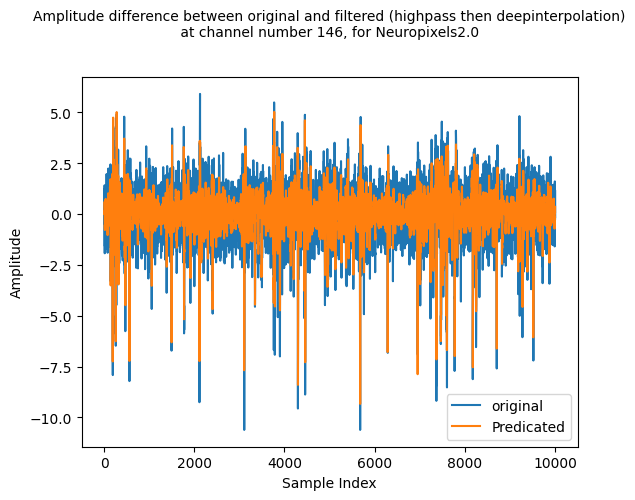

In [34]:
plt.figure()
plt.title("Amplitude difference between original and filtered (highpass then deepinterpolation)" 
          "\n at channel number 146, for Neuropixels2.0 \n \n", fontsize=10, loc='center')
plt.plot(traces_or[:, 145], label="original"), # blue is for original recording
plt.plot(traces_hp_di[:, 145], label="Predicated"), #orange is for for filtered signal
plt.legend()

plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

#plt.savefig('/home/buccino/Visual Results/Spikeinterface/Neuropixels1.0/Amplitude/original and filtered (highpass then deepinterpolation).png')


In [35]:
# diff_bp_di dimensions (10005, 384)
diff_hp_di = diff_hp_di

# Calculate the sum of all rows using np.sum() with axis=1
average_diff_hp_di = np.mean(diff_hp_di, axis=1)
average_diff_hp_di.shape


(10005,)

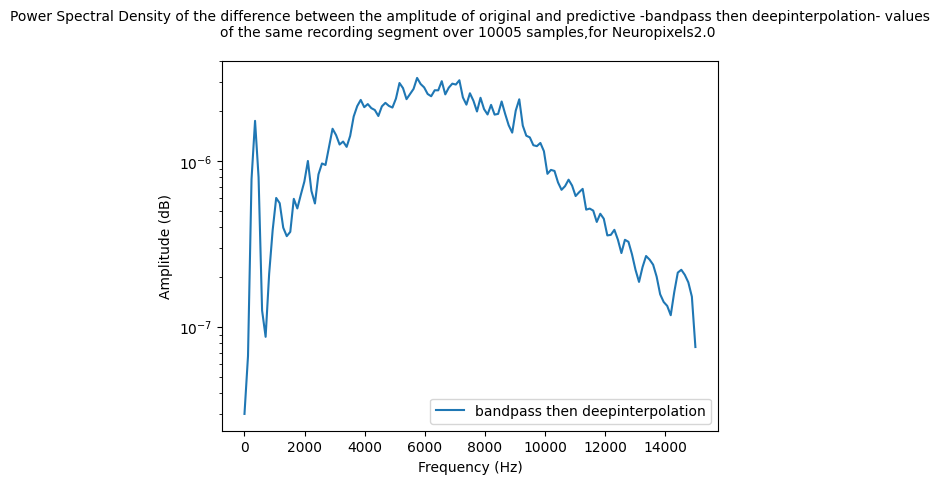

In [36]:
x= average_diff_hp_di
fs= 30000
f, Pxx = signal.welch(x, fs=fs)

# Plot the power spectrum density

fig, ax = plt.subplots()
ax.semilogy(f, Pxx,   label='bandpass then deepinterpolation')

ax.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (dB)')
ax.set_title('Power Spectral Density of the difference between the amplitude of original and predictive -bandpass then deepinterpolation- values\n' 
             "of the same recording segment over 10005 samples,for Neuropixels2.0 \n", size=10)
plt.show()

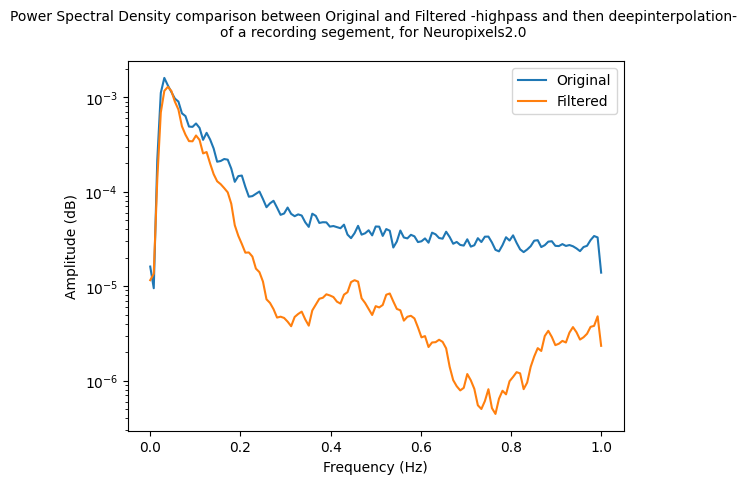

In [37]:
fs = 30000 # Sampling frequency
N = 3005 # Number of samples
t = np.linspace(0, N/fs, N)
x = traces_or[:, 145]
x1= traces_hp_di[:, 145]
 

# Calculate the power spectrum density using Welch's method
f, Pxx = signal.welch(x, fs=fs, nperseg=256)
f1, Pxx1 = signal.welch(x1, fs=fs, nperseg=256)

# Plot the power spectrum density

fig, ax = plt.subplots()
ax.semilogy(f*(2/fs), Pxx, label='Original')
ax.semilogy(f1*(2/fs), Pxx1, label='Filtered')


ax.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (dB)')
ax.set_title('Power Spectral Density comparison between Original and Filtered -highpass and then deepinterpolation- \n' 
             "of a recording segement, for Neuropixels2.0 \n", size=10)
plt.show()

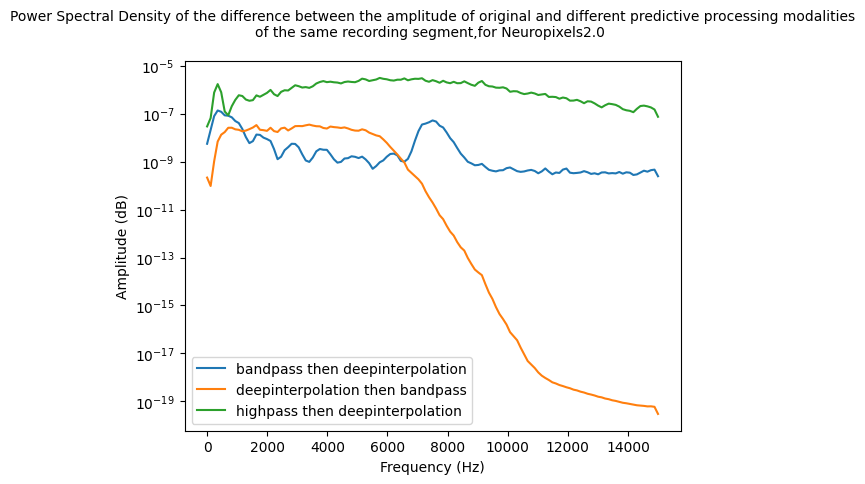

In [38]:
fs = 30000 # Sampling frequency
N = 10005 # Number of samples
t = np.linspace(0, N/fs, N)

x= average_diff_bp_di
x1= average_diff_di_bp1
x2= average_diff_hp_di

# Calculate the power spectrum density using Welch's method
f, Pxx = signal.welch(x, fs=fs, nperseg=256)
f1, Pxx1 = signal.welch(x1, fs=fs, nperseg=256)
f2, Pxx2 = signal.welch(x2, fs=fs, nperseg=256)

# Plot the power spectrum density

fig, ax = plt.subplots()
ax.semilogy(f, Pxx,   label='bandpass then deepinterpolation')
ax.semilogy(f, Pxx1, label='deepinterpolation then bandpass')
ax.semilogy(f, Pxx2, label='highpass then deepinterpolation')


ax.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (dB)')
ax.set_title('Power Spectral Density of the difference between the amplitude of original and different predictive processing modalities\n' 
             "of the same recording segment,for Neuropixels2.0 \n", size=10)
plt.show()

Operations on error

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest

x= average_diff_bp_di
x1= average_diff_di_bp1
x2= average_diff_hp_di

mu = np.mean(x)
sigma = np.std(x)

mu1 = np.mean(x1)
sigma1 = np.std(x1)

mu2 = np.mean(x2)
sigma2 = np.std(x2)

print('diff_bp_di: mean', mu, 'std-dev:', sigma)
print('diff_di_bp: mean', mu1, 'std-dev:', sigma1)
print('diff_hp_di: mean', mu2, 'std-dev:', sigma2)


diff_bp_di: mean 0.024688393 std-dev: 0.012374053
diff_di_bp: mean -7.800088e-06 std-dev: 0.011547866
diff_hp_di: mean -0.046358306 std-dev: 0.13789871


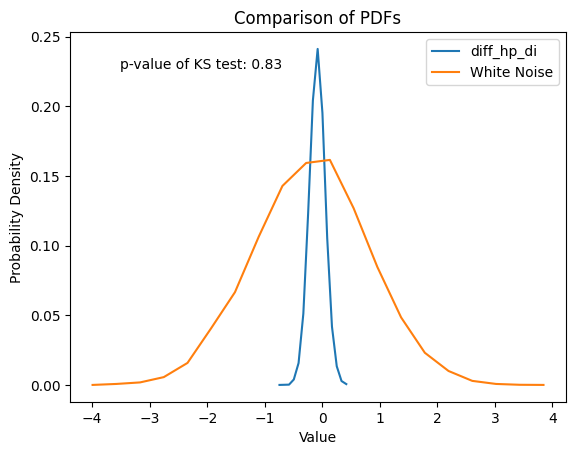

In [40]:
data = x2
hist, bin_edges = np.histogram(data, bins=15, density=True)
pdf = hist / np.sum(hist)

# white noise
white_noise = np.random.normal(0, 1, size=len(data))
hist_white, bin_edges_white = np.histogram(white_noise, bins=20, density=True)
pdf_white = hist_white / np.sum(hist_white)

test_statistic, p_value = kstest(pdf, pdf_white)


plt.plot(bin_edges[:-1], pdf, label='diff_hp_di')
plt.plot(bin_edges_white[:-1], pdf_white, label='White Noise')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Comparison of PDFs')
plt.legend()
plt.text(0.1, 0.9, 'p-value of KS test: {:.2f}'.format(p_value), transform=plt.gca().transAxes)
plt.show()

plotting log function

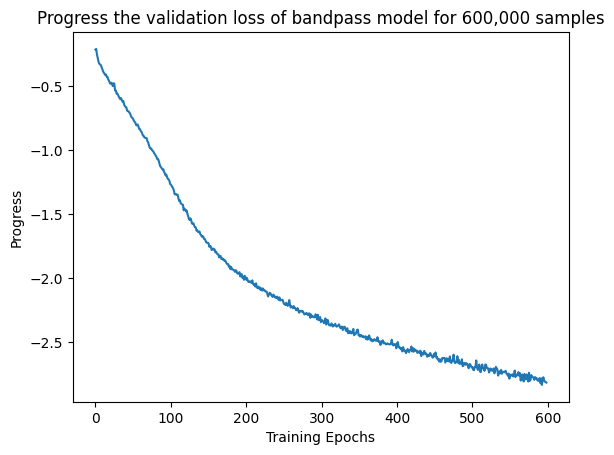

In [42]:
# Load the npy file
data = np.load('/home/buccino/codes/ephys-deepinterpolation/spikeinterface/deepinterpolation_recording/trained_models/test_training_bp_filter_t20s_v0.5s/first_test_unet_single_ephys_1024_mean_absolute_error_val_loss.npy')

# Take the logarithm of the data
log_data = np.log(data)

# Plot the data
plt.plot(log_data)
plt.xlabel('Training Epochs')
plt.ylabel('Progress')
plt.title('Progress the validation loss of bandpass model for 600,000 samples')
plt.show()

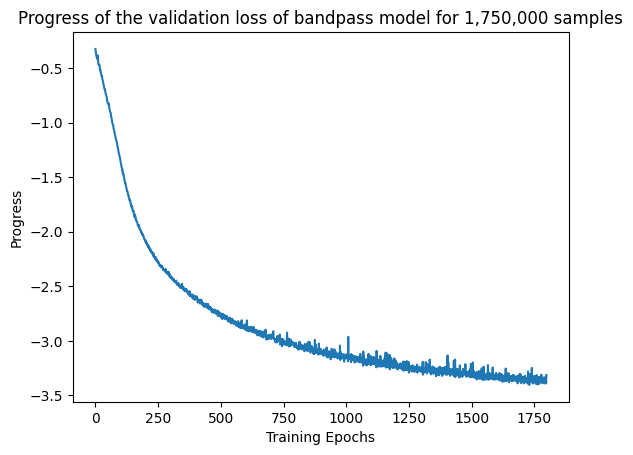

In [45]:
# Load the npy file
data = np.load('/home/buccino/codes/ephys-deepinterpolation/spikeinterface/deepinterpolation_recording/trained_models/test_training_bp_filter_t60_v0.5s_assertion/first_test_unet_single_ephys_1024_mean_absolute_error_val_loss.npy')

# Take the logarithm of the data
log_data = np.log(data)

# Plot the data
plt.plot(log_data)
plt.xlabel('Training Epochs')
plt.ylabel('Progress')
plt.title('Progress of the validation loss of bandpass model for 1,750,000 samples')
plt.show()

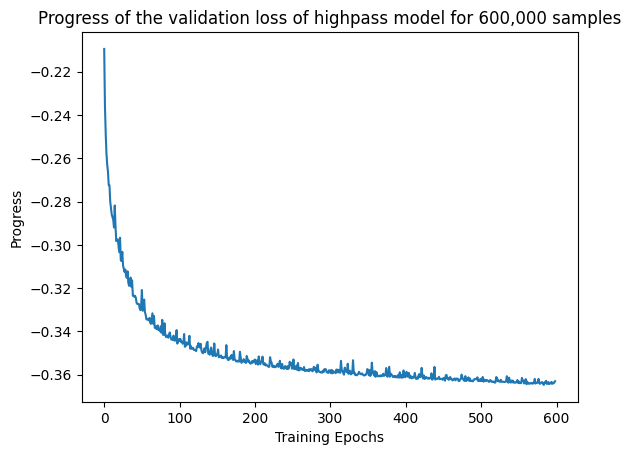

In [46]:
# Load the npy file
data = np.load('/home/buccino/codes/ephys-deepinterpolation/spikeinterface/deepinterpolation_recording/trained_models//test_training_hp_filter_t20s_v0.5s/first_test_unet_single_ephys_1024_mean_absolute_error_val_loss.npy')

# Take the logarithm of the data
log_data = np.log(data)

# Plot the data
plt.plot(log_data)
plt.xlabel('Training Epochs')
plt.ylabel('Progress')
plt.title('Progress of the validation loss of highpass model for 600,000 samples')
plt.show()